In [3]:
import os
import pickle
import bson
import pandas as pd
import pandas as pd
import numpy as np
import os
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)

## 2 Pointers

In [4]:
X = pd.read_csv('X_2P.csv')
y = pd.read_csv('y_2P.csv')

In [5]:
categorical_features = ['Location', 'Zone','Period','LBA_position', 'year']

# Convert the columns to 'category' type
for col in categorical_features:
    X[col] = X[col].astype('category')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#LIGHTGBM

# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.720011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19443
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 341
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")


Train-------------------------------
Train Accuracy: 0.6221101122436702
Train Precision: 0.5855590978864093
Train Recall: 0.8482749183216162
Train F1 Score: 0.6928488099978345
Train AUC ROC: 0.7303426645270475
Test-------------------------------
Test Accuracy: 0.6177090734077418
Test Precision: 0.5827789513510105
Test Recall: 0.8428060096208649
Test F1 Score: 0.6890779798130422
Test AUC ROC: 0.7221948046592966
Optimum Threshold for Maximum F1 Score: 0.36


#### Saving values

In [9]:
y_train_pred_2p = y_train_pred
best_threshold_2p = best_threshold
y_pred_2p = y_pred
y_train_2p = y_train
y_test_2p = y_test
X_2p = X

Text(0.5, 1.0, 'Feature Importance')

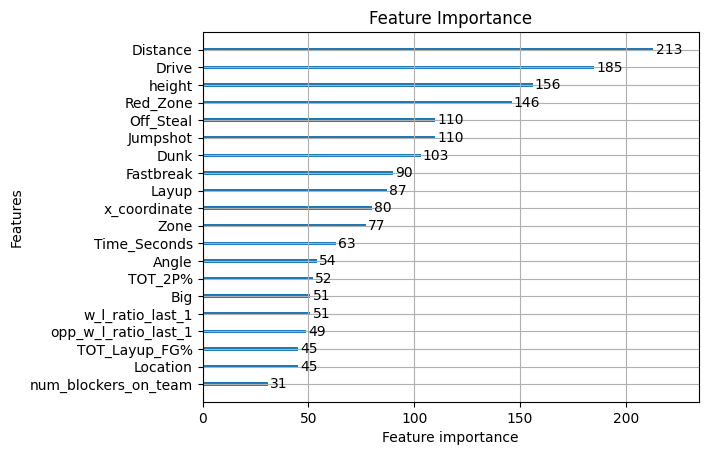

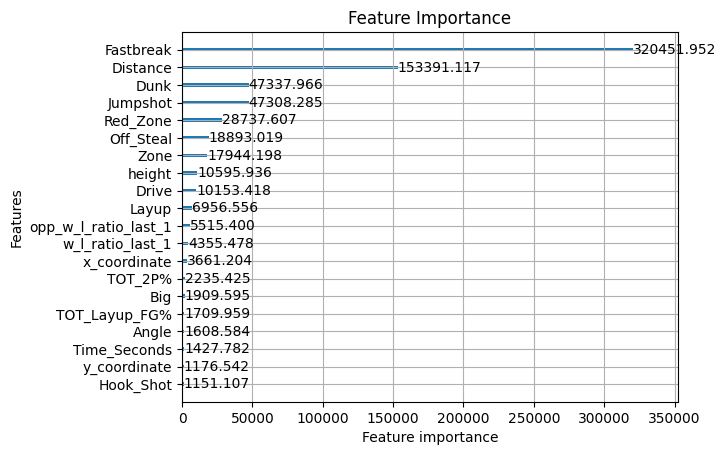

In [10]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

## 3 Pointer

In [11]:
X = pd.read_csv('X_3P.csv')
y = pd.read_csv('y_3P.csv')

In [12]:
categorical_features = ['Location', 'Zone','Period','LBA_position', 'year']

# Convert the columns to 'category' type
for col in categorical_features:
    X[col] = X[col].astype('category')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71294, number of negative: 138282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12767
[LightGBM] [Info] Number of data points in the train set: 209576, number of used features: 228
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340182 -> initscore=-0.662483
[LightGBM] [Info] Start training from score -0.662483


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")


Train-------------------------------
Train Accuracy: 0.36508474252777035
Train Precision: 0.34683878262508244
Train Recall: 0.9809941930597246
Train F1 Score: 0.5124843830717994
Train AUC ROC: 0.6033150417145206
Test-------------------------------
Test Accuracy: 0.3608168718389159
Test Precision: 0.3444979871894025
Test Recall: 0.9755714045038468
Test F1 Score: 0.5091889673769675
Test AUC ROC: 0.5591975821941713
Optimum Threshold for Maximum F1 Score: 0.26


#### Saving values

In [16]:
y_train_pred_3p = y_train_pred
best_threshold_3p = best_threshold
y_pred_3p = y_pred
y_train_3p = y_train
y_test_3p = y_test
X_3p = X

Text(0.5, 1.0, 'Feature Importance')

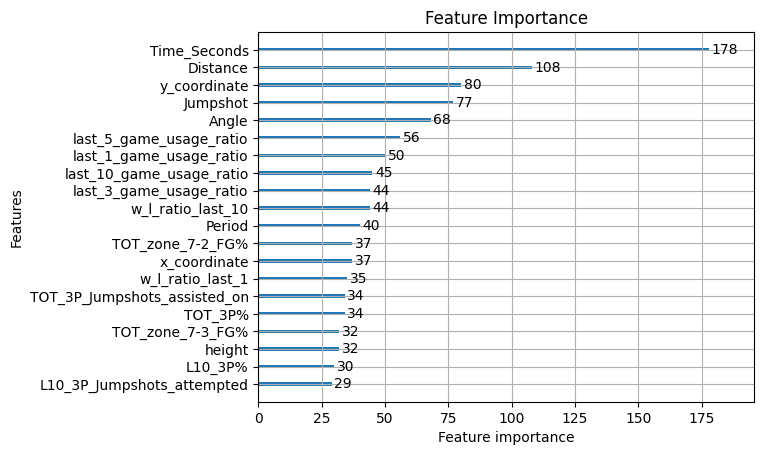

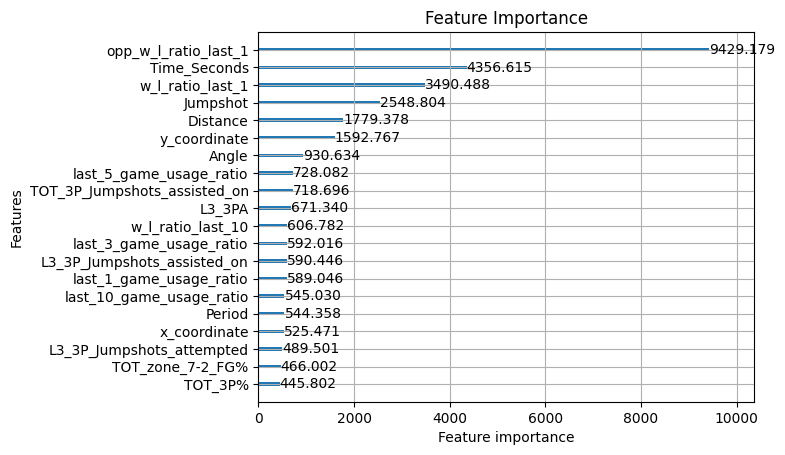

In [17]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

## Additional probability and performance evaluation

In [18]:
# Function to plot probabilities
def plot_probabilities(probs, title):
    sns.histplot(probs, kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_combined_probabilities(prob_2p, prob_3p):
    weighted_2p = prob_2p * 2
    weighted_3p = prob_3p * 3
    return np.concatenate([weighted_2p, weighted_3p])

In [19]:
# Displaying the best thresholds
print(f"Best threshold for 2-pointers: {best_threshold_2p}")
print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 2-pointers: 0.36
Best threshold for 3-pointers: 0.26


In [20]:
# Calculate overall points for train and test data
overall_points_train = calculate_combined_probabilities(y_train_pred_2p, y_train_pred_3p)
overall_points_test = calculate_combined_probabilities(y_pred_2p, y_pred_3p)

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


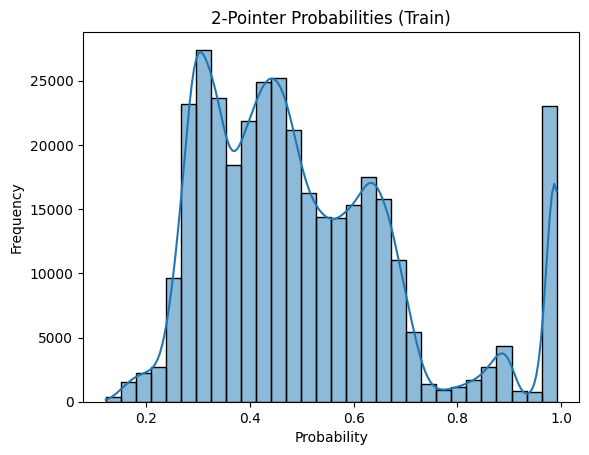

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


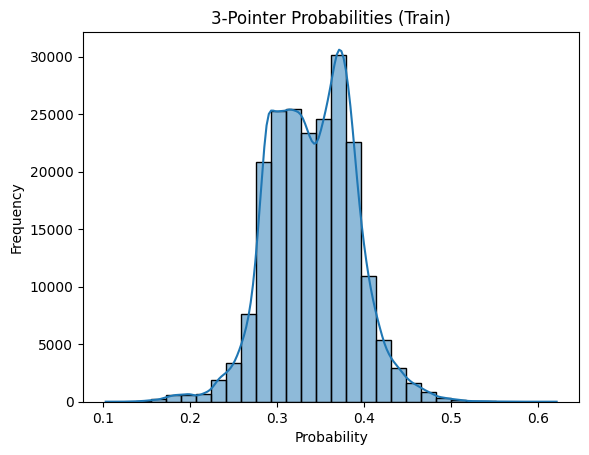

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


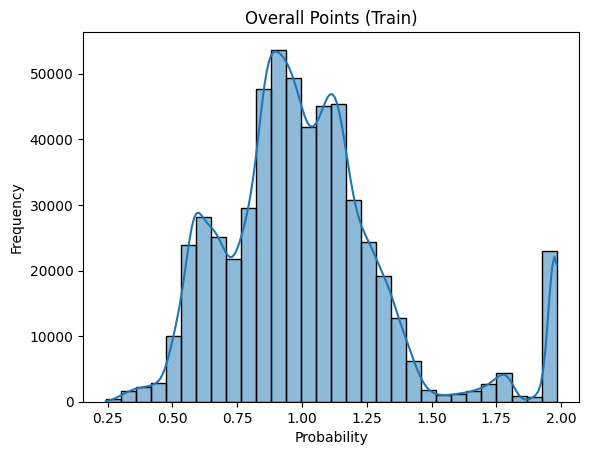

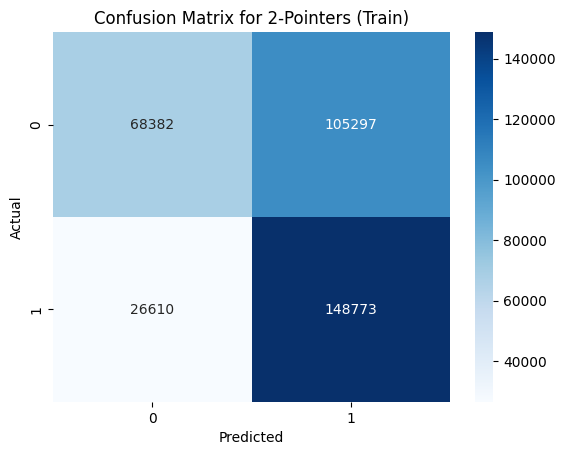

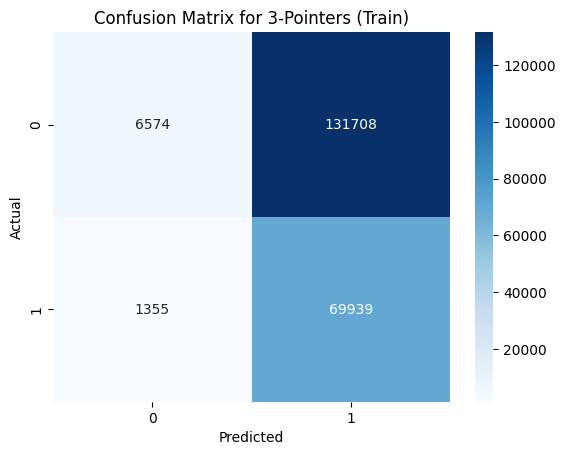

In [21]:
# Plot for train set
plot_probabilities(y_train_pred_2p, '2-Pointer Probabilities (Train)')
plot_probabilities(y_train_pred_3p, '3-Pointer Probabilities (Train)')
plot_probabilities(overall_points_train, 'Overall Points (Train)')
plot_confusion_matrix(y_train_2p, y_train_pred_2p_binary, 'Confusion Matrix for 2-Pointers (Train)')
plot_confusion_matrix(y_train_3p, y_train_pred_3p_binary, 'Confusion Matrix for 3-Pointers (Train)')

In [22]:
print(y_train_pred_2p.shape)
print(y_train_2p.shape)
print(y_train_pred_3p.shape)
print(y_train_3p.shape)

y_train_pred_2p = np.array(y_train_pred_2p)
y_train_2p = np.array(y_train_2p)
y_train_pred_3p = np.array(y_train_pred_3p)
y_train_3p = np.array(y_train_3p)

y_train_2p = y_train_2p.reshape(-1)
y_train_3p = y_train_3p.reshape(-1)

print(y_train_pred_2p.shape)
print(y_train_2p.shape)
print(y_train_pred_3p.shape)
print(y_train_3p.shape)

(349062,)
(349062, 1)
(209576,)
(209576, 1)
(349062,)
(349062,)
(209576,)
(209576,)


c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

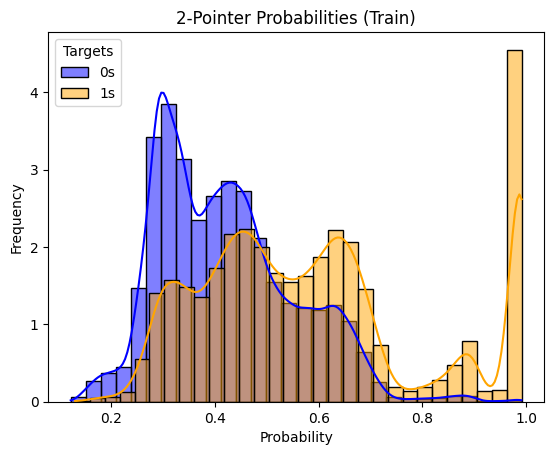

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

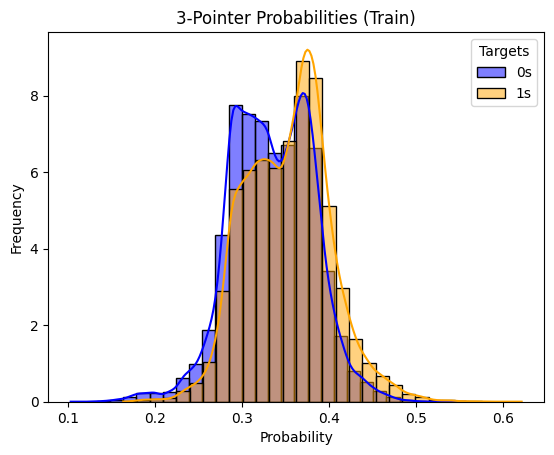

In [23]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


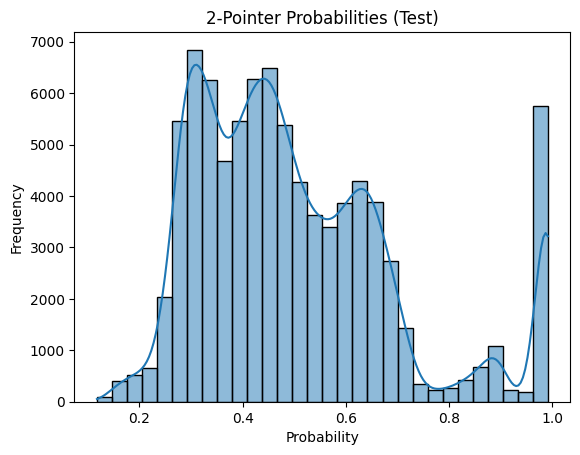

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


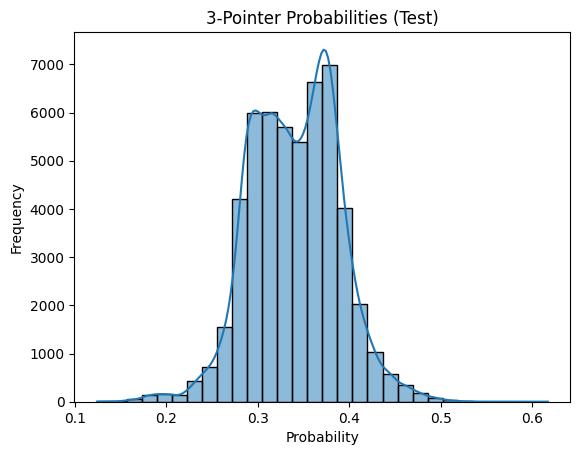

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


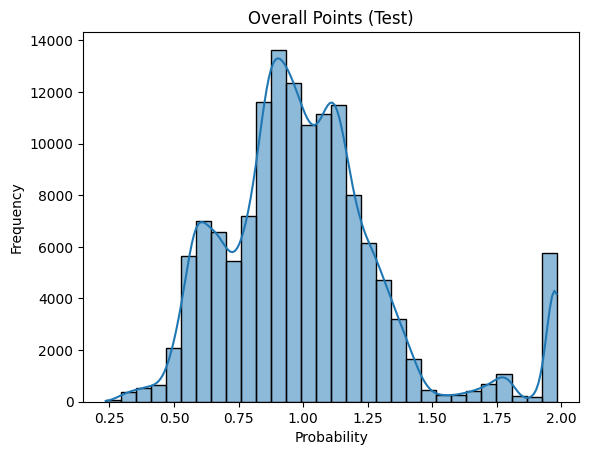

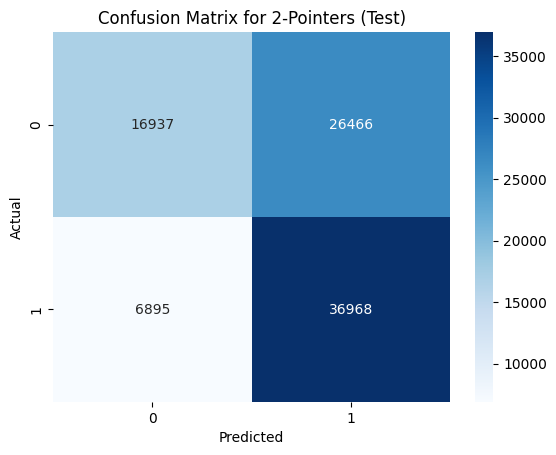

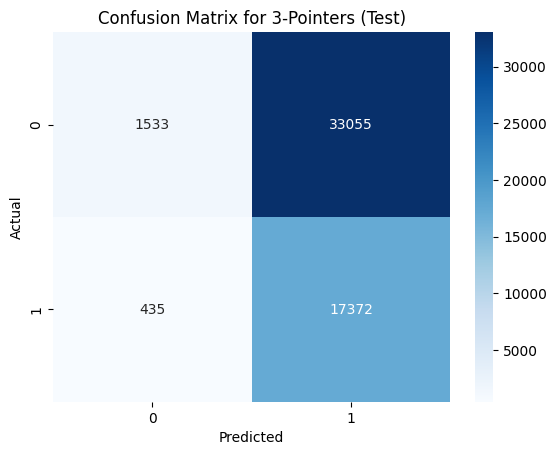

In [24]:
# Plot for test set
plot_probabilities(y_pred_2p, '2-Pointer Probabilities (Test)')
plot_probabilities(y_pred_3p, '3-Pointer Probabilities (Test)')
plot_probabilities(overall_points_test, 'Overall Points (Test)')
plot_confusion_matrix(y_test_2p, y_pred_2p_binary, 'Confusion Matrix for 2-Pointers (Test)')
plot_confusion_matrix(y_test_3p, y_pred_3p_binary, 'Confusion Matrix for 3-Pointers (Test)')

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

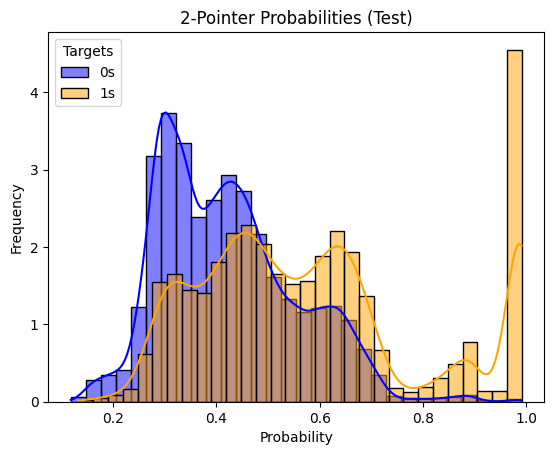

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

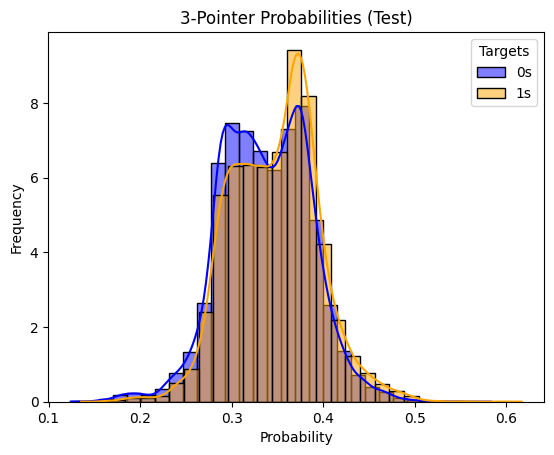

In [25]:
y_test_pred_2p = np.array(y_pred_2p)
y_test_pred_3p = np.array(y_pred_3p)
y_test_2p = np.array(y_test_2p)
y_test_3p = np.array(y_test_3p)

y_test_2p = y_test_2p.reshape(-1)
y_test_3p = y_test_3p.reshape(-1)

y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

### Reduced feature probability comparison

#### 2 pointer model

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.575721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19443
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 341
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763
Train-------------------------------
Train Accuracy: 0.6221101122436702
Train Precision: 0.5855590978864093
Train Recall: 0.8482749183216162
Train F1 Score: 0.6928488099978345
Train AUC ROC: 0.7303426645270475
Test-------------------------------
Test Accuracy: 0.6177090734077418
Test Precision: 0.5827789513510105
Test Recall: 0.8428060096208

Text(0.5, 1.0, 'Feature Importance')

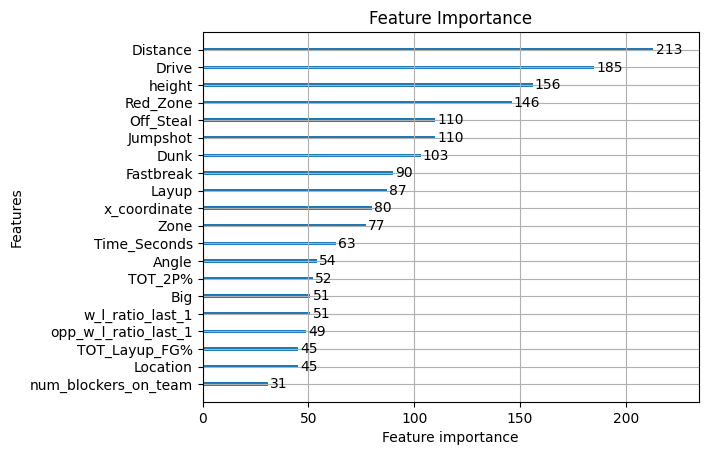

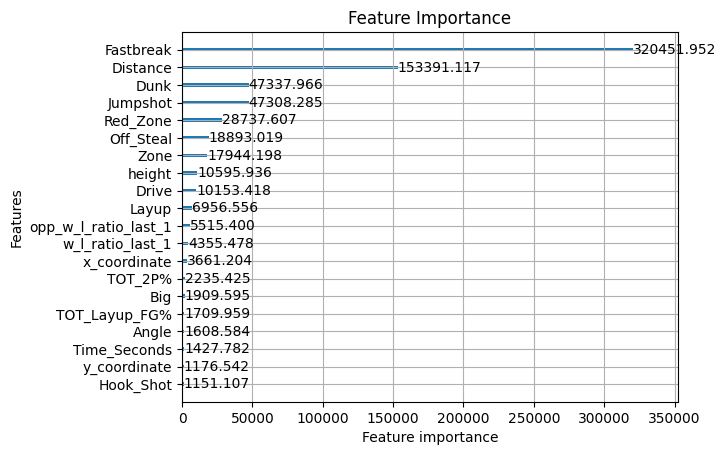

In [71]:
X = pd.read_csv('X_2P.csv')
y = pd.read_csv('y_2P.csv')

categorical_features = ['Location', 'Zone','Period','LBA_position', 'year']

# Convert the columns to 'category' type
for col in categorical_features:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

lgb.plot_importance(bst, importance_type='split', max_num_features=25)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=25)
plt.title("Feature Importance")

In [72]:
# List of reduced features
reduced_features_2p =  ['Fastbreak', 'Distance', 'Jumpshot', 'Dunk', 'Red Zone', 'Off Steal', 'Zone', 'height', 'Drive', 'Layup', 'opp_w_l_ratio_last_1', 'TOT 2P%', 'w_l_ratio_last_1', 'x_coordinate', 'Time_Seconds', 'TOT Hook Shots made', 'TOT Layup FG%', 'Angle', 'TOT Jumpshots made', 'Big', 'opp_w_l_ratio_last_10', 'Hook Shot', 'TOT 1 attempted', 'L10 Jumpshots made', 'L10 Layup FG%']

# Selecting reduced features for training and testing
X_train_reduced_2p = X_train[reduced_features_2p]
X_test_reduced_2p = X_test[reduced_features_2p]

categorical_features_reduced_2p = [feat for feat in categorical_features if feat in reduced_features_2p]
print(categorical_features_reduced_2p)

# Create a LightGBM dataset for the reduced model
train_data_reduced_2p = lgb.Dataset(X_train_reduced_2p, label=y_train, categorical_feature=categorical_features_reduced_2p)
test_data_reduced_2p = lgb.Dataset(X_test_reduced_2p, label=y_test, categorical_feature=categorical_features_reduced_2p)

# Train the reduced model
bst_reduced_2p = lgb.train(params, train_data_reduced_2p, num_round, valid_sets=[test_data_reduced_2p])

# Make predictions with the reduced model
y_pred_reduced_2p = bst_reduced_2p.predict(X_test_reduced_2p, num_iteration=bst_reduced_2p.best_iteration)

['Zone']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763


In [73]:
# Find the best threshold on the training data for reduced model
y_train_pred_reduced_2p = bst_reduced_2p.predict(X_train_reduced_2p, num_iteration=bst_reduced_2p.best_iteration)
best_threshold_reduced_2p = find_best_threshold(y_train, y_train_pred_reduced_2p)

# Apply the best threshold to get binary predictions for reduced model
y_train_pred_binary_reduced_2p = [1 if x >= best_threshold_reduced_2p else 0 for x in y_train_pred_reduced_2p]
y_pred_binary_reduced_2p = [1 if x >= best_threshold_reduced_2p else 0 for x in y_pred_reduced_2p]

# Performance Metrics for Train data for reduced model
train_accuracy_reduced_2p = accuracy_score(y_train, y_train_pred_binary_reduced_2p)
train_precision_reduced_2p = precision_score(y_train, y_train_pred_binary_reduced_2p)
train_recall_reduced_2p = recall_score(y_train, y_train_pred_binary_reduced_2p)
train_f1_reduced_2p = f1_score(y_train, y_train_pred_binary_reduced_2p)
train_auc_roc_reduced_2p = roc_auc_score(y_train, y_train_pred_reduced_2p)

# Performance Metrics for Test data for reduced model
test_accuracy_reduced_2p = accuracy_score(y_test, y_pred_binary_reduced_2p)
test_precision_reduced_2p = precision_score(y_test, y_pred_binary_reduced_2p)
test_recall_reduced_2p = recall_score(y_test, y_pred_binary_reduced_2p)
test_f1_reduced_2p = f1_score(y_test, y_pred_binary_reduced_2p)
test_auc_roc_reduced_2p = roc_auc_score(y_test, y_pred_reduced_2p)

# Print performance metrics for reduced model
print('Reduced 2-Pointer Model-------------------------------')
print(f"Train Accuracy: {train_accuracy_reduced_2p}")
print(f"Train Precision: {train_precision_reduced_2p}")
print(f"Train Recall: {train_recall_reduced_2p}")
print(f"Train F1 Score: {train_f1_reduced_2p}")
print(f"Train AUC ROC: {train_auc_roc_reduced_2p}")
print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy_reduced_2p}")
print(f"Test Precision: {test_precision_reduced_2p}")
print(f"Test Recall: {test_recall_reduced_2p}")
print(f"Test F1 Score: {test_f1_reduced_2p}")
print(f"Test AUC ROC: {test_auc_roc_reduced_2p}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold_reduced_2p}")

Reduced 2-Pointer Model-------------------------------
Train Accuracy: 0.617830070302697
Train Precision: 0.5812615653816673
Train Recall: 0.8561149028127013
Train F1 Score: 0.6924096777243098
Train AUC ROC: 0.7282210948763875
Test-------------------------------
Test Accuracy: 0.6137212660142553
Test Precision: 0.5786814617363544
Test Recall: 0.8512869616761279
Test F1 Score: 0.6889998062534021
Test AUC ROC: 0.7217523646511472
Optimum Threshold for Maximum F1 Score: 0.35


count    87266.000000
mean         0.000030
std          0.016006
min         -0.128665
25%         -0.008709
50%         -0.000470
75%          0.008334
max          0.169425
dtype: float64


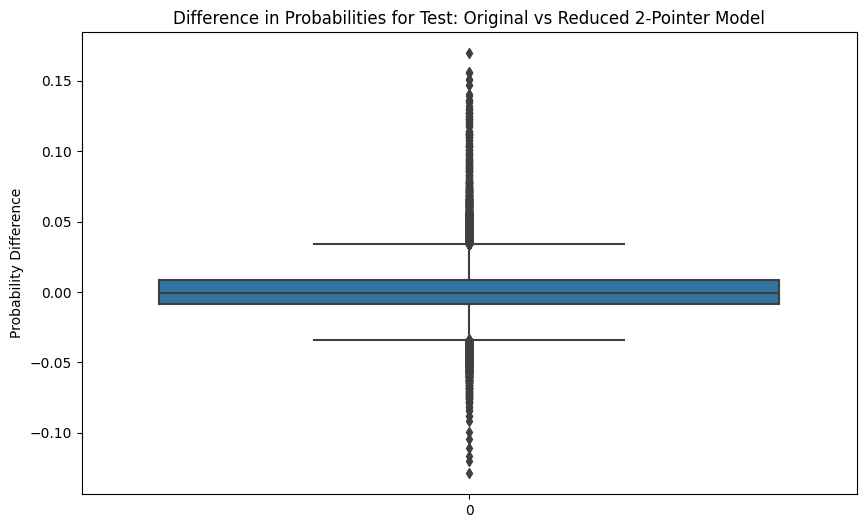

In [74]:
# Calculate the difference in probabilities between original and reduced models
prob_diff_2p = y_pred - y_pred_reduced_2p
prob_diff_2p_series = pd.Series(prob_diff_2p)
statistics_2p = prob_diff_2p_series.describe()
print(statistics_2p)

# Box plot of the difference in probabilities
plt.figure(figsize=(10, 6))
sns.boxplot(prob_diff_2p)
plt.title('Difference in Probabilities for Test: Original vs Reduced 2-Pointer Model')
plt.ylabel('Probability Difference')
plt.show()

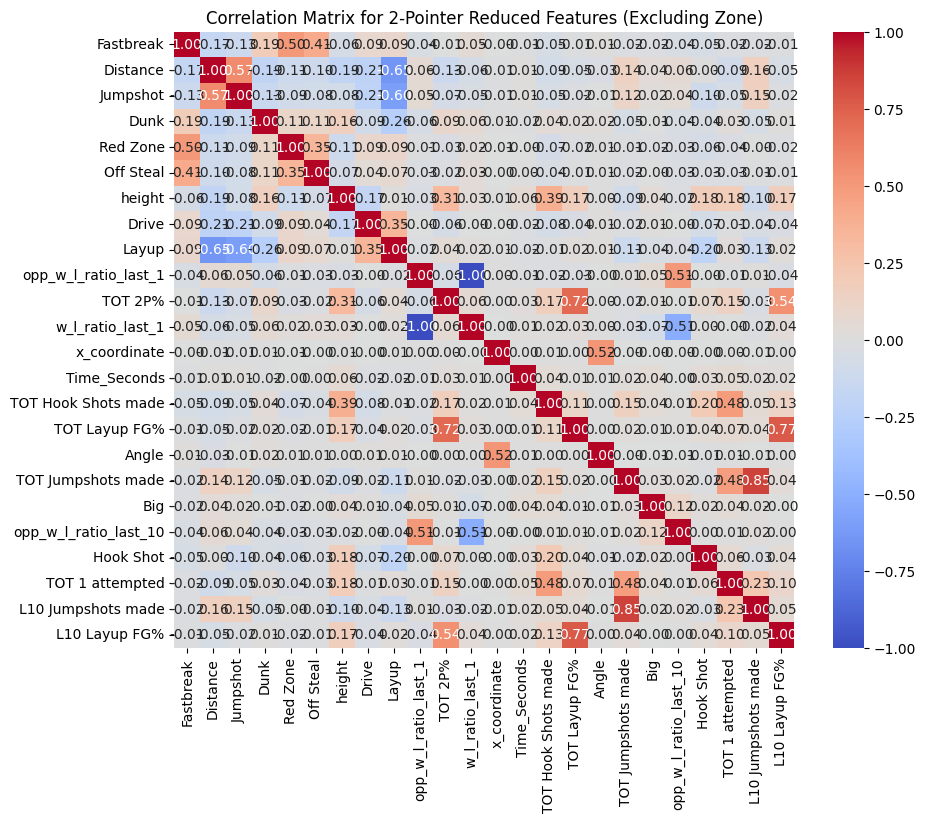

In [75]:
# List of reduced features for 2-pointer model excluding 'Zone'
reduced_features_2p_no_zone = [feature for feature in reduced_features_2p if feature != 'Zone']

# Identify boolean columns in the new 2-pointer reduced features list
bool_cols_2p_no_zone = X[reduced_features_2p_no_zone].select_dtypes(include='bool').columns

# Convert boolean features to 1/0 for 2-pointer model
X[bool_cols_2p_no_zone] = X[bool_cols_2p_no_zone].astype(int)

# Compute the correlation matrix for 2-pointer reduced features excluding 'Zone'
corr_2p_no_zone = X[reduced_features_2p_no_zone].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_2p_no_zone, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title('Correlation Matrix for 2-Pointer Reduced Features (Excluding Zone)')
plt.show()

#### 3 pointer model

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71294, number of negative: 138282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12767
[LightGBM] [Info] Number of data points in the train set: 209576, number of used features: 228
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340182 -> initscore=-0.662483
[LightGBM] [Info] Start training from score -0.662483
Train-------------------------------
Train Accuracy: 0.36508474252777035
Train Precision: 0.34683878262508244
Train Recall: 0.9809941930597246
Train F1 Score: 0.5124843830717994
Train AUC ROC: 0.6033150417145206
Test-------------------------------
Test Accuracy: 0.3608168718389159
Test Precision: 0.3444979871894025
Test Recall: 0.9755714045

Text(0.5, 1.0, 'Feature Importance')

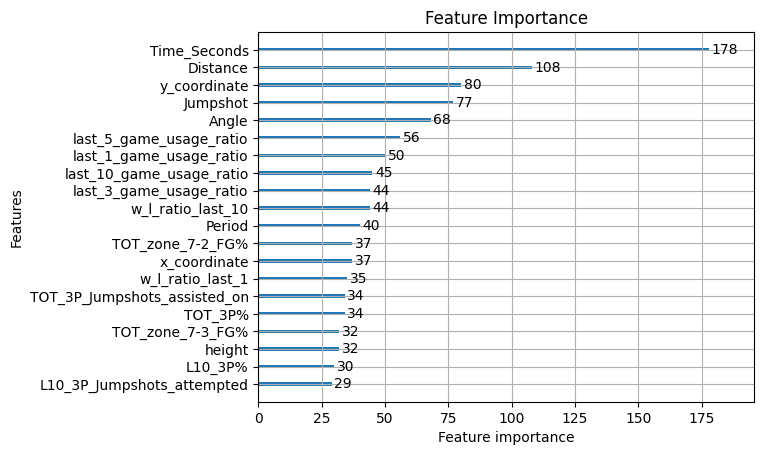

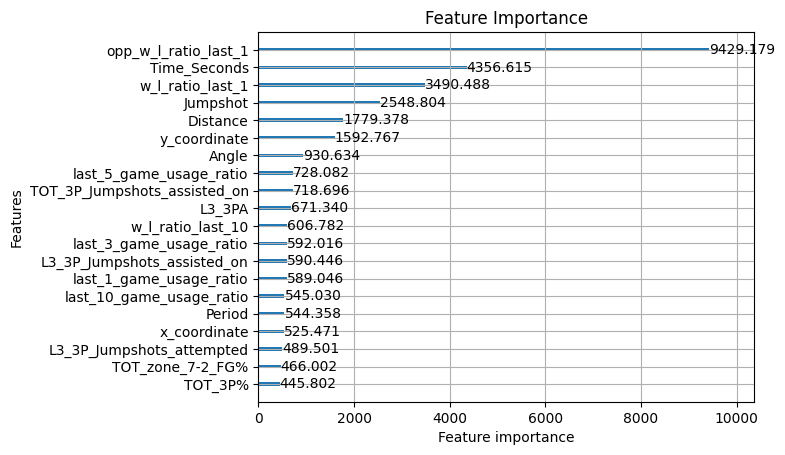

In [76]:
X = pd.read_csv('X_3P.csv')
y = pd.read_csv('y_3P.csv')

categorical_features = ['Location', 'Zone','Period','LBA_position', 'year']

# Convert the columns to 'category' type
for col in categorical_features:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

lgb.plot_importance(bst, importance_type='split', max_num_features=25)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=25)
plt.title("Feature Importance")

In [77]:
# List of reduced features for 3-pointer model
reduced_features_3p = ['opp_w_l_ratio_last_1', 'Time_Seconds', 'Jumpshot', 'Distance', 'y_coordinate', 'w_l_ratio_last_1', 'L3 3P Jumpshots attempted', 'last_5_game_usage_ratio', 'last_1_game_usage_ratio', 'last_3_game_usage_ratio', 'Angle', 'L10 3P Jumpshots attempted', 'TOT 3P Jumpshots assisted on', 'TOT 3P%', 'TOT 3P Jumpshots attempted', 'w_l_ratio_last_10', 'TOT 3P Jumpshots assisted%', 'TOT zone 7-2 FG%', 'L3 3P Jumpshots assisted on', 'L10 3P%', 'L5 Jumpshots 3P%', 'last_10_game_usage_ratio', 'TOT zone 6-2 FG%', 'TOT 7-2 attempted']

# Selecting reduced features for training and testing
X_train_reduced_3p = X_train[reduced_features_3p]
X_test_reduced_3p = X_test[reduced_features_3p]

categorical_features_reduced_3p = [feat for feat in categorical_features if feat in reduced_features_3p]
print(categorical_features_reduced_3p)

# Create a LightGBM dataset for the reduced model
train_data_reduced_3p = lgb.Dataset(X_train_reduced_3p, label=y_train, categorical_feature=categorical_features_reduced_3p)
test_data_reduced_3p = lgb.Dataset(X_test_reduced_3p, label=y_test, categorical_feature=categorical_features_reduced_3p)

# Train the reduced model
bst_reduced_3p = lgb.train(params, train_data_reduced_3p, num_round, valid_sets=[test_data_reduced_3p])

# Make predictions with the reduced model
y_pred_reduced_3p = bst_reduced_3p.predict(X_test_reduced_3p, num_iteration=bst_reduced_3p.best_iteration)

[]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71294, number of negative: 138282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4020
[LightGBM] [Info] Number of data points in the train set: 209576, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340182 -> initscore=-0.662483
[LightGBM] [Info] Start training from score -0.662483


In [78]:
# Find the best threshold on the training data for reduced model
y_train_pred_reduced_3p = bst_reduced_3p.predict(X_train_reduced_3p, num_iteration=bst_reduced_3p.best_iteration)
best_threshold_reduced_3p = find_best_threshold(y_train_3p, y_train_pred_reduced_3p)

# Apply the best threshold to get binary predictions for reduced model
y_train_pred_binary_reduced_3p = [1 if x >= best_threshold_reduced_3p else 0 for x in y_train_pred_reduced_3p]
y_pred_binary_reduced_3p = [1 if x >= best_threshold_reduced_3p else 0 for x in y_pred_reduced_3p]

# Performance Metrics for Train data for reduced model
train_accuracy_reduced_3p = accuracy_score(y_train_3p, y_train_pred_binary_reduced_3p)
train_precision_reduced_3p = precision_score(y_train_3p, y_train_pred_binary_reduced_3p)
train_recall_reduced_3p = recall_score(y_train_3p, y_train_pred_binary_reduced_3p)
train_f1_reduced_3p = f1_score(y_train_3p, y_train_pred_binary_reduced_3p)
train_auc_roc_reduced_3p = roc_auc_score(y_train_3p, y_train_pred_reduced_3p)

# Performance Metrics for Test data for reduced model
test_accuracy_reduced_3p = accuracy_score(y_test_3p, y_pred_binary_reduced_3p)
test_precision_reduced_3p = precision_score(y_test_3p, y_pred_binary_reduced_3p)
test_recall_reduced_3p = recall_score(y_test_3p, y_pred_binary_reduced_3p)
test_f1_reduced_3p = f1_score(y_test_3p, y_pred_binary_reduced_3p)
test_auc_roc_reduced_3p = roc_auc_score(y_test_3p, y_pred_reduced_3p)

# Print performance metrics for reduced model
print('Reduced 3-Pointer Model-------------------------------')
print(f"Train Accuracy: {train_accuracy_reduced_3p}")
print(f"Train Precision: {train_precision_reduced_3p}")
print(f"Train Recall: {train_recall_reduced_3p}")
print(f"Train F1 Score: {train_f1_reduced_3p}")
print(f"Train AUC ROC: {train_auc_roc_reduced_3p}")
print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy_reduced_3p}")
print(f"Test Precision: {test_precision_reduced_3p}")
print(f"Test Recall: {test_recall_reduced_3p}")
print(f"Test F1 Score: {test_f1_reduced_3p}")
print(f"Test AUC ROC: {test_auc_roc_reduced_3p}")

print(f"Optimum Threshold for Maximum F1 Score: {best_threshold_reduced_3p}")

Reduced 3-Pointer Model-------------------------------
Train Accuracy: 0.3909226247280223
Train Precision: 0.3523264467574395
Train Recall: 0.942940499901815
Train F1 Score: 0.5129797787104159
Train AUC ROC: 0.593940346168407
Test-------------------------------
Test Accuracy: 0.38375799217482587
Test Precision: 0.34821709326457456
Test Recall: 0.9328354018082776
Test F1 Score: 0.5071286826438712
Test AUC ROC: 0.5587819660866647
Optimum Threshold for Maximum F1 Score: 0.28


count    52395.000000
mean         0.000186
std          0.015909
min         -0.104373
25%         -0.007835
50%          0.000294
75%          0.008075
max          0.271117
dtype: float64


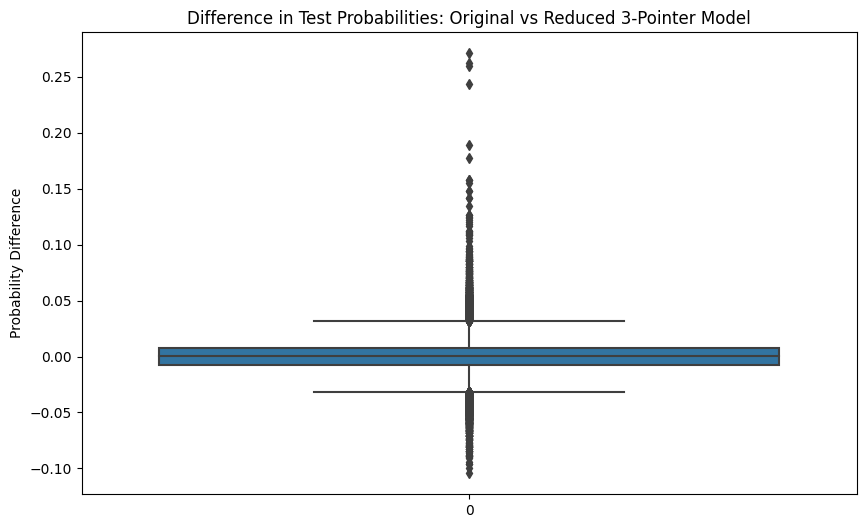

In [79]:
# Calculate the difference in probabilities between original and reduced models for 3-pointer
prob_diff_3p = y_pred_3p - y_pred_reduced_3p

prob_diff_3p_series = pd.Series(prob_diff_3p)
statistics = prob_diff_3p_series.describe()
print(statistics)

# Box plot of the difference in probabilities for 3-pointer
plt.figure(figsize=(10, 6))
sns.boxplot(prob_diff_3p)
plt.title('Difference in Test Probabilities: Original vs Reduced 3-Pointer Model')
plt.ylabel('Probability Difference')
plt.show()


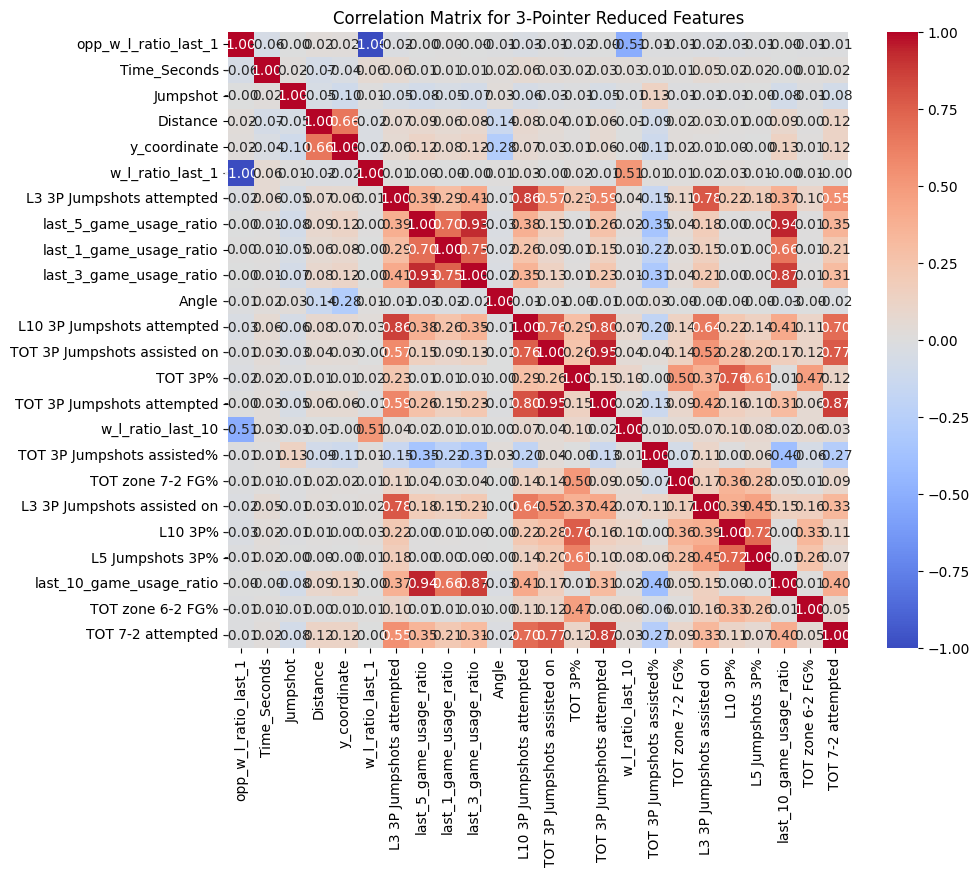

In [80]:
# Compute the correlation matrix for 3-pointer reduced features
corr_3p = X[reduced_features_3p].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_3p, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title('Correlation Matrix for 3-Pointer Reduced Features')
plt.show()

## L1 regularization in LightGBM

### 2 POINTERS

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.374426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19443
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 341
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Text(0.5, 1.0, 'Feature Importance')

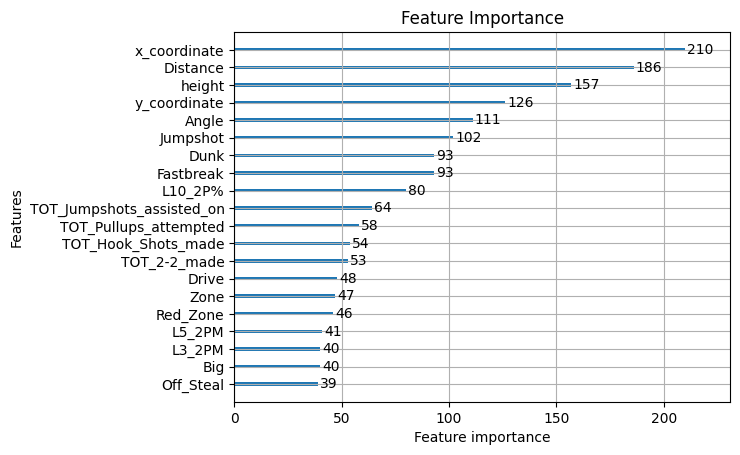

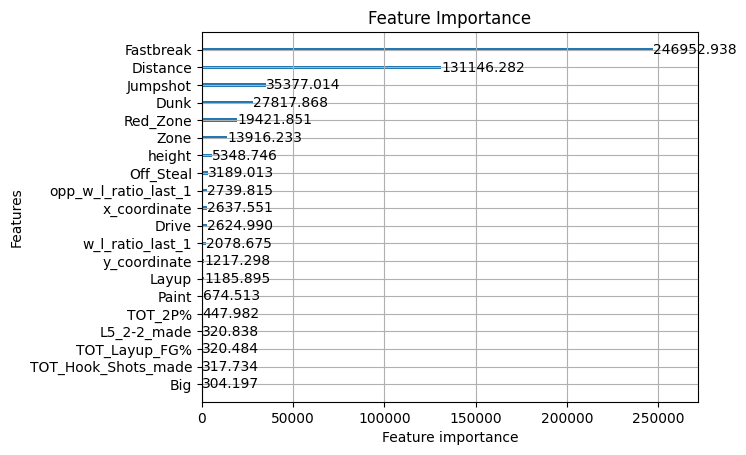

In [77]:
X = pd.read_csv('X_2P.csv')
y = pd.read_csv('y_2P.csv')

categorical_features = ['Location', 'Zone','Period','LBA_position', 'year']

# Convert the columns to 'category' type
for col in categorical_features:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'lambda_l1': 1000
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [78]:
# Get feature importances
feature_importances = bst.feature_importance(importance_type='split')

# Create a dataframe for feature importances
feature_importance_df = pd.DataFrame({
    'feature_name': bst.feature_name(),
    'importance': feature_importances
})

# Features with non-zero importance
features_with_importance = feature_importance_df[feature_importance_df['importance'] > 0]

# Features with zero importance
features_no_importance = feature_importance_df[feature_importance_df['importance'] == 0]

# Print the number of features with more than 0 importance and with 0 importance
print(f"Number of features with more than 0 importance: {len(features_with_importance)}")
print(f"Number of features with 0 importance: {len(features_no_importance)}")

# Print the dataframe for features with more than 0 importance
print("Features with more than 0 importance:")
print(features_with_importance.sort_values(by='importance', ascending=False))


Number of features with more than 0 importance: 179
Number of features with 0 importance: 162
Features with more than 0 importance:
         feature_name  importance
3        x_coordinate         210
0            Distance         186
42             height         157
4        y_coordinate         126
1               Angle         111
..                ...         ...
252        L10_1_made           1
90   L1_3-2_attempted           1
83        L1_4-2_made           1
293   TOT_Floater_FG%           1
104  L1_4-3_attempted           1

[179 rows x 2 columns]


### 3 POINTERS

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71294, number of negative: 138282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12767
[LightGBM] [Info] Number of data points in the train set: 209576, number of used features: 228
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340182 -> initscore=-0.662483
[LightGBM] [Info] Start training from score -0.662483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Text(0.5, 1.0, 'Feature Importance')

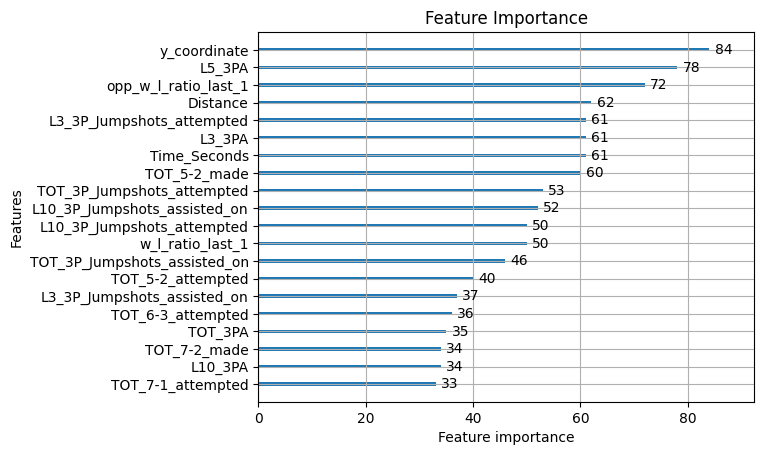

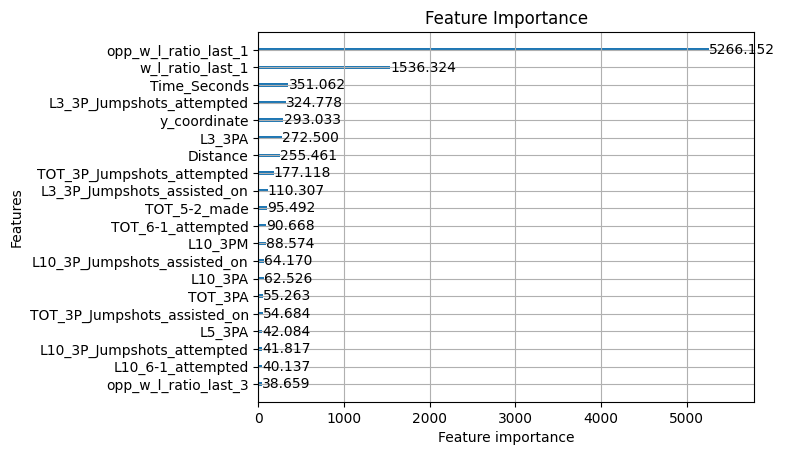

In [79]:
X = pd.read_csv('X_3P.csv')
y = pd.read_csv('y_3P.csv')

categorical_features = ['Location', 'Zone','Period','LBA_position', 'year']

# Convert the columns to 'category' type
for col in categorical_features:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'lambda_l1': 1000
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [ ]:
# Get feature importances
feature_importances = bst.feature_importance(importance_type='split')

# Create a dataframe for feature importances
feature_importance_df = pd.DataFrame({
    'feature_name': bst.feature_name(),
    'importance': feature_importances
})

# Features with non-zero importance
features_with_importance = feature_importance_df[feature_importance_df['importance'] > 0]

# Features with zero importance
features_no_importance = feature_importance_df[feature_importance_df['importance'] == 0]

# Print the number of features with more than 0 importance and with 0 importance
print(f"Number of features with more than 0 importance: {len(features_with_importance)}")
print(f"Number of features with 0 importance: {len(features_no_importance)}")

# Print the dataframe for features with more than 0 importance
print("Features with more than 0 importance:")
print(features_with_importance.sort_values(by='importance', ascending=False))


Number of features with more than 0 importance: 204
Number of features with 0 importance: 31
Features with more than 0 importance:
           feature_name  importance
6          Time_Seconds         175
0              Distance         113
7              Jumpshot          93
1                 Angle          80
4          y_coordinate          77
..                  ...         ...
61          L1_6-1_made           1
59          L1_5-1_made           1
42         LBA_position           1
40                Small           1
127  L5_3P_Pullups_made           1

[204 rows x 2 columns]


#### VIF check

In [61]:
def calculate_vif(X):
    # Adding an intercept term to the feature set.
    X = sm.add_constant(X)

    bool_cols = [col for col in X if X[col].dtype == bool]  # changed np.bool to bool
    X[bool_cols] = X[bool_cols].astype(int)

    # null_columns = X.columns[X.isnull().any()]
    
    # if null_columns.any():
    #     print("The following columns in the DataFrame have null values:")
    #     for col in null_columns:
    #         print(col, ":", X[col].isnull().sum())  # prints the column name and count of nulls
    # else:
    #     print("All good")

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    # print(X.dtypes)
    
    # for i in range(X.shape[1]):
    #     print(f'Column {i}:')
    #     print(X.iloc[:, i].dtypes)
    #     print(X.iloc[:, i].isnull().sum())
    #     print(np.isfinite(X.iloc[:, i]).sum()) # This line should not throw an error if data is numeric and finite
    #     variance_inflation_factor(X.values, i)
    
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

def remove_high_vif_features(X, threshold=2.5, categorical_features=[]):
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
    X = X.replace([np.inf, -np.inf], np.nan)
    for col in X:
        if X[col].isnull().any():  
            X[col] = X[col].fillna(X[col].median())
    X = sm.add_constant(X)
    
    while True:
        vif_data = calculate_vif(X)
        max_vif = vif_data["VIF"].max()
        if max_vif < threshold:
            break
        removed_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]
        X = X.drop(columns=[removed_feature["feature"]])
        print(f"Removed: {removed_feature['feature']} with VIF = {removed_feature['VIF']}")
    X = X.drop(columns=['const'])
    return X

In [62]:
# Apply the function to your datasets
X_2pointer_updated = remove_high_vif_features(X_2p, 2.5, categorical_features)
X_3pointer_updated = remove_high_vif_features(X_3p, 2.5, categorical_features)

KeyboardInterrupt: 